In [15]:
import os
import plaid
import requests
import datetime
import json
import pandas as pd
%matplotlib inline
from collections import Counter

In [16]:
def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

In [17]:
PLAID_CLIENT_ID = os.getenv('PLAID_CLIENT_ID')
PLAID_SECRET = os.getenv('PLAID_SBX_SECRET_KEY')
PLAID_PUBLIC_KEY = os.getenv('PLAID_PUBLIC_KEY')
PLAID_ENV = os.getenv('PLAID_DEVELOPMENT_KEY', 'sandbox')
PLAID_PRODUCTS = os.getenv('PLAID_PRODUCTS', 'transactions')


In [18]:
client = plaid.Client(client_id=PLAID_CLIENT_ID, 
                      secret=PLAID_SECRET, 
                      public_key=PLAID_PUBLIC_KEY, 
                      environment='sandbox')


# Plaid Access Token

In this section, you will use the plaid-python api to generate the correct authentication tokens to access data in the free developer Sandbox. This mimics how you might connect to your own account or a customer account, but due to privacy issues, this homework will only require connecting to and analyzing the fake data from the developer sandbox that Plaid provides. 

Complete the following steps to generate an access token:
1. Create a client to connect to plaid
2. Use the client to generate a public token and request the following items: 
['transactions', 'income', 'assets']
3. Exchange the public token for an access token
4. Test the access token by requesting and printing the available test accounts

### 1. Create a client to connect to plaid

In [19]:
INSTITUTION_ID = "ins_109508"

In [20]:
api_key = PLAID_PUBLIC_KEY

api_request = 'https://www.plaid.com/api/'

### 2. Generate a public token

In [21]:
create_tkn_response = client.Sandbox.public_token.create(INSTITUTION_ID, 
                                                         ['transactions',
                                                          'income',
                                                          'assets'])


### 3. Exchange the public token for an access token


In [22]:
exchange_response = client.Item.public_token.exchange(create_tkn_response
                                                      ['public_token'])


### 4. Fetch Accounts

In [23]:
access_token = exchange_response["access_token"]

-----------

# Account Transactions with Plaid

In this section, you will use the Plaid Python SDK to connect to the Developer Sandbox account and grab a list of transactions. You will need to complete the following steps:


1. Use the access token to fetch the transactions for the last 90 days
2. Print the categories for each transaction type
3. Create a new DataFrame using the following fields from the JSON transaction data: `date, name, amount, category`. (For categories with more than one label, just use the first category label in the list)
4. Convert the data types to the appropriate types (i.e. datetimeindex for the date and float for the amount)

### 1. Fetch the Transactions for the last 90 days

In [26]:
start_date = f'{datetime.datetime.now() + datetime.timedelta(-90):%Y-%m-%d}'
end_date = f'{datetime.datetime.now():%Y-%m-%d}' 

transactions_response = client.Transactions.get(access_token, start_date, end_date)

#print (json.dumps(transactions_response, indent = 4, sort_keys = True))


### 2. Print the categories for each transaction


In [42]:
category_df = pd.DataFrame()
for category in transactions_response['transactions']:
    print(category['category'][:3])
    

['Travel', 'Airlines and Aviation Services']
['Travel', 'Taxi']
['Food and Drink', 'Restaurants']
['Payment']
['Food and Drink', 'Restaurants', 'Fast Food']
['Shops', 'Sporting Goods']
['Payment', 'Credit Card']
['Travel', 'Taxi']
['Transfer', 'Debit']
['Transfer', 'Deposit']
['Recreation', 'Gyms and Fitness Centers']
['Travel', 'Airlines and Aviation Services']
['Food and Drink', 'Restaurants', 'Fast Food']
['Food and Drink', 'Restaurants', 'Coffee Shop']
['Food and Drink', 'Restaurants']
['Transfer', 'Credit']
['Travel', 'Airlines and Aviation Services']
['Travel', 'Taxi']
['Food and Drink', 'Restaurants']
['Payment']
['Food and Drink', 'Restaurants', 'Fast Food']
['Shops', 'Sporting Goods']
['Payment', 'Credit Card']
['Travel', 'Taxi']
['Transfer', 'Debit']
['Transfer', 'Deposit']
['Recreation', 'Gyms and Fitness Centers']
['Travel', 'Airlines and Aviation Services']
['Food and Drink', 'Restaurants', 'Fast Food']
['Food and Drink', 'Restaurants', 'Coffee Shop']
['Food and Drink', 'R

### 3. Create a new DataFrame using the following fields from the JSON transaction data: date, name, amount, category. 

(For categories with more than one label, just use the first category label in the list)

In [57]:
transaction_date = []
transaction_name = []
transaction_amount = []
transaction_category = []

for item in transactions_response['transactions']:
    transaction_date.append(item['date'])
    transaction_name.append(item['name'])
    transaction_amount.append(item['amount'])
    transaction_category.append(item['category'][0])

In [58]:
date = pd.Series(transaction_date)
name = pd.Series(transaction_name)
category = pd.Series(transaction_category)
amount = pd.Series(transaction_amount)

In [59]:
transaction_data_df = pd.concat([date,name,amount,category], axis='columns', join='inner')

In [60]:
transaction_data_df.columns = ['Date','Name','Amount','Category']
transaction_data_df.index = pd.to_datetime(transaction_data_df.index, infer_datetime_format=True)
transaction_data_df.set_index(transaction_data_df['Date'], inplace = True)
transaction_data_df.drop(columns = ['Date'], inplace = True)

transaction_data_df.head()

,Name,Amount,Category
Date,,,
2020-01-31,United Airlines,500.00,Travel
2020-01-29,Uber,6.33,Travel
2020-01-26,Tectra Inc,500.00,Food and Drink
2020-01-25,AUTOMATIC PAYMENT - THANK,2078.50,Payment
2020-01-25,KFC,500.00,Food and Drink


### 4. Convert the data types to the appropriate types 

(i.e. datetimeindex for the date and float for the amount)

In [65]:
transaction_data_df.index = pd.to_datetime(transaction_data_df.index, infer_datetime_format=True)


----------

# Income Analysis with Plaid

In this section, you will use the Plaid Sandbox to complete the following:
1. Determine the previous year's gross income and print the results
2. Determine the current monthly income and print the results
3. Determine the projected yearly income and print the results

In [66]:
income_response = client.Income.get(access_token)
print (json.dumps(income_response, indent = 4, sort_keys = True))

{
    "income": {
        "income_streams": [
            {
                "confidence": 0.99,
                "days": 690,
                "monthly_income": 500,
                "name": "UNITED AIRLINES"
            }
        ],
        "last_year_income": 6000,
        "last_year_income_before_tax": 7285,
        "max_number_of_overlapping_income_streams": 1,
        "number_of_income_streams": 1,
        "projected_yearly_income": 6085,
        "projected_yearly_income_before_tax": 7389
    },
    "request_id": "U4PQ8v7d41dHVMY"
}


In [67]:
print (f"Last year's gross income: ${income_response['income']['last_year_income']}")
print (f"Current monthly income: ${income_response['income']['income_streams'][0]['monthly_income']}")
print (f"Projected yearly income: ${income_response['income']['projected_yearly_income']}")

Last year's gross income: $6000
Current monthly income: $500
Projected yearly income: $6085


-------

# Budget Analysis
In this section, you will use the transactions DataFrame to analyze the customer's budget

1. Calculate the total spending per category and print the results (Hint: groupby or count transactions per category)
2. Generate a bar chart with the number of transactions for each category 
3. Calculate the expenses per month
4. Plot the total expenses per month

### Calculate the expenses per category

In [68]:
transaction_data_df.groupby('Category').sum()

,Amount
Category,
Food and Drink,3317.19
Payment,6310.50
Recreation,235.50
Shops,1500.00
Transfer,20537.34
Travel,535.19


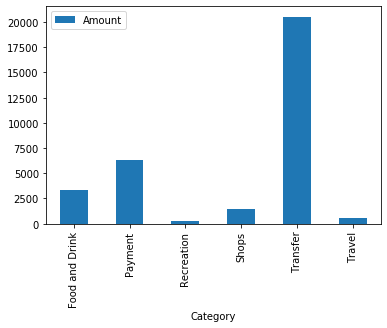

In [69]:
transaction_data_df.groupby('Category').sum().plot(kind='bar')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x118ea8cd0>],
      dtype=object)

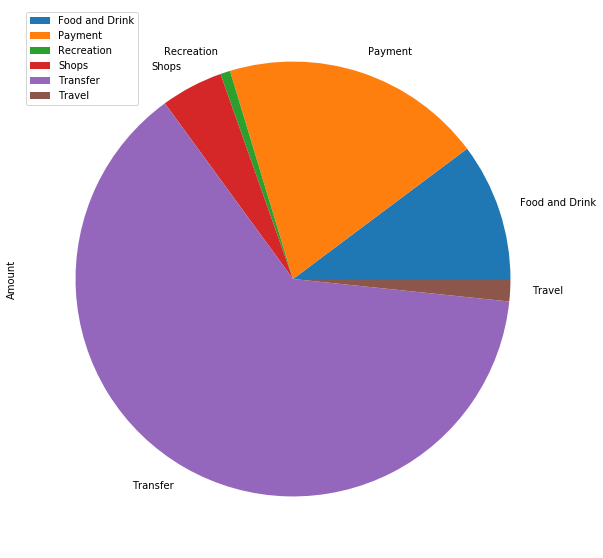

In [70]:
transaction_data_df.groupby('Category').sum().plot(kind='pie',subplots=True, figsize=(25,10))

### Calculate the expenses per month

In [71]:
transaction_data_df.groupby(['Category','Date']).sum()


Amount
Category       Date               
Food and Drink 2019-11-13    89.40
               2019-11-14    16.33
               2019-11-26   500.00
               2019-11-27   500.00
               2019-12-13    89.40
               2019-12-14    16.33
               2019-12-26   500.00
               2019-12-27   500.00
               2020-01-12    89.40
               2020-01-13    16.33
               2020-01-25   500.00
               2020-01-26   500.00
Payment        2019-11-17    25.00
               2019-11-26  2078.50
               2019-12-17    25.00
               2019-12-26  2078.50
               2020-01-16    25.00
               2020-01-25  2078.50
Recreation     2019-11-15    78.50
               2019-12-15    78.50
               2020-01-14    78.50
Shops          2019-11-26   500.00
               2019-12-26   500.00
               2020-01-25   500.00
Transfer       2019-11-12    -4.22
               2019-11-16  6850.00
               2019-12-12    -4.22
               2019-12-16  6850.00
               2020-01-11    -4.22
               2020-01-15  6850.00
Travel         2019-11-02   500.00
               2019-11-15  -500.00
               2019-11-17     5.40
               2019-11-30     6.33
               2019-12-02   500.00
               2019-12-15  -500.00
               2019-12-17     5.40
               2019-12-30     6.33
               2020-01-01   500.00
               2020-01-14  -500.00
               2020-01-16     5.40
               2020-01-29     6.33
               2020-01-31   500.00

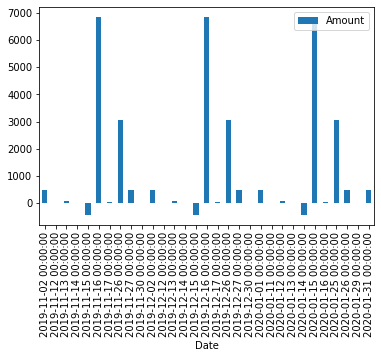

In [72]:
transaction_data_df.groupby(['Date']).sum().plot(kind='bar')